In [2]:
# Create an ML algorithm that can accurately predict the time a car will spend on the test bench 
# based on the vehicle configuration

# Agenda
# 1. If for any column(s), the variance is equal to zero, then you need to remove those variable(s)
# 2. Check for null and unique values for test and train sets
# 3. Apply label encoder for categorical variables
# 4. Perform dimensaionlity reduction with PCA
# 5. Predict the test_df values using xgboost

In [3]:
# Importing the required libraries
# Loading the train/test data
# The lowercase alphabets are categorical variables
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd

train = pd.read_csv('MERCtrain.csv')
train.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


In [4]:
print('Size of training set')
print(train.shape)

Size of training set
(4209, 378)


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Columns: 378 entries, ID to X385
dtypes: float64(1), int64(369), object(8)
memory usage: 12.1+ MB


In [6]:
# Separating y column as this is for prediction output
y_train = train['y'].values
y_train

array([130.81,  88.53,  76.26, ..., 109.22,  87.48, 110.85])

In [7]:
# A lot of columns that have an X 
# Let's check for the same 
# 376 features with X
colums_x = [c for c in train.columns if 'X' in c]

# info about colums_x
print(len(colums_x))
print(train[colums_x].dtypes.value_counts())

376
int64     368
object      8
dtype: int64


In [8]:
# Looking at the test dataset for simiilar features
test = pd.read_csv('MERCtest.csv')
test.head()


,ID,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,1,az,v,n,f,d,t,a,w,0,...,0,0,0,1,0,0,0,0,0,0
1,2,t,b,ai,a,d,b,g,y,0,...,0,0,1,0,0,0,0,0,0,0
2,3,az,v,as,f,d,a,j,j,0,...,0,0,0,1,0,0,0,0,0,0
3,4,az,l,n,f,d,z,l,n,0,...,0,0,0,1,0,0,0,0,0,0
4,5,w,s,as,c,d,y,i,m,0,...,1,0,0,0,0,0,0,0,0,0


In [9]:
print('Size of training set')
test.shape

Size of training set


(4209, 377)

In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Columns: 377 entries, ID to X385
dtypes: int64(369), object(8)
memory usage: 12.1+ MB


In [11]:
# Creating the final dataset
# Removing unwanted columns (ID); y has been removed earlier
final_column = list(set(train.columns) - set(['ID', 'y']))

x_train = train[final_column]
# x_train
x_test = test[final_column]
# x_test

In [12]:
# Searching for null values
# Creating a function for the same
def detect(df):
    if df.isnull().any().any():
        print("Yes")
    else:
        print("No")

detect(x_train)
detect(x_test)

# Observation : There are no missing values.

No
No


In [13]:
## EDA
# Integer Columns Analysis
unique_value_dict = {}
for col in x_train.columns:
    if col not in ["ID", "y", "X0", "X1", "X2", "X3", "X4", "X5", "X6", "X8"]:
        unique_value = str(np.sort(x_train[col].unique()).tolist())
        t_list = unique_value_dict.get(unique_value, [])
        t_list.append(col)
        unique_value_dict[unique_value] = t_list[:]

In [14]:
for unique_val, columns in unique_value_dict.items():
    print("Columns containing the unique values : ",unique_val)
    print(columns)
    print("-----------------------------------------------------------")

Columns containing the unique values :  [0, 1]
['X380', 'X58', 'X94', 'X139', 'X159', 'X360', 'X251', 'X273', 'X301', 'X22', 'X60', 'X253', 'X370', 'X37', 'X300', 'X338', 'X13', 'X99', 'X142', 'X377', 'X100', 'X19', 'X47', 'X376', 'X184', 'X177', 'X14', 'X120', 'X65', 'X33', 'X242', 'X129', 'X151', 'X324', 'X215', 'X230', 'X10', 'X118', 'X134', 'X186', 'X364', 'X74', 'X239', 'X64', 'X280', 'X146', 'X276', 'X200', 'X17', 'X238', 'X105', 'X82', 'X275', 'X326', 'X168', 'X209', 'X285', 'X332', 'X187', 'X243', 'X339', 'X358', 'X221', 'X241', 'X305', 'X148', 'X223', 'X384', 'X291', 'X352', 'X45', 'X265', 'X32', 'X41', 'X343', 'X164', 'X97', 'X371', 'X354', 'X254', 'X130', 'X79', 'X179', 'X77', 'X136', 'X175', 'X214', 'X18', 'X363', 'X166', 'X75', 'X262', 'X318', 'X246', 'X50', 'X132', 'X309', 'X216', 'X194', 'X176', 'X258', 'X368', 'X135', 'X26', 'X95', 'X232', 'X119', 'X31', 'X272', 'X51', 'X84', 'X281', 'X90', 'X269', 'X220', 'X24', 'X162', 'X207', 'X316', 'X88', 'X52', 'X150', 'X55', 'X28

In [15]:
# Removal of columns with a variance of 0
# means columns that have only one unique value 0. 

for column in final_column:
    check = len(np.unique(x_train[column]))
    if check == 1:
        x_train.drop(column, axis = 1, inplace=True) 
        x_test.drop(column, axis = 1, inplace=True)

x_train.head()

,X380,X58,X94,X139,X159,X360,X251,X273,X301,X22,...,X284,X274,X80,X156,X190,X367,X350,X154,X348,X23
0,0,1,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,1,1,0,0,0,0,1,0
2,0,1,0,0,0,0,0,1,0,0,...,0,1,1,0,0,0,1,0,1,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,1,0,1,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,1,0,1,0


In [16]:
## Label encoding the Categorical columns
from sklearn import preprocessing
for f in ["X0", "X1", "X2", "X3", "X4", "X5", "X6", "X8"]:
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_train[f].values)) 
        x_train[f] = lbl.transform(list(x_train[f].values))
        #x_test[f] = lbl.transform(list(x_test[f].values))   ## as values in test dataset differs from train set
        
print(x_train.head())

   X380  X58  X94  X139  X159  X360  X251  X273  X301  X22  ...  X284  X274  \
0     0    1    0     0     0     0     0     1     0    0  ...     0     0   
1     0    0    0     0     0     0     0     1     0    0  ...     0     0   
2     0    1    0     0     0     0     0     1     0    0  ...     0     1   
3     0    0    0     0     0     0     0     1     0    0  ...     0     0   
4     0    0    0     0     0     0     0     1     0    0  ...     0     0   

   X80  X156  X190  X367  X350  X154  X348  X23  
0    0     1     0     0     0     0     0    0  
1    1     1     0     0     0     0     1    0  
2    1     0     0     0     1     0     1    0  
3    1     0     0     0     1     0     1    0  
4    1     0     0     0     1     0     1    0  

[5 rows x 364 columns]


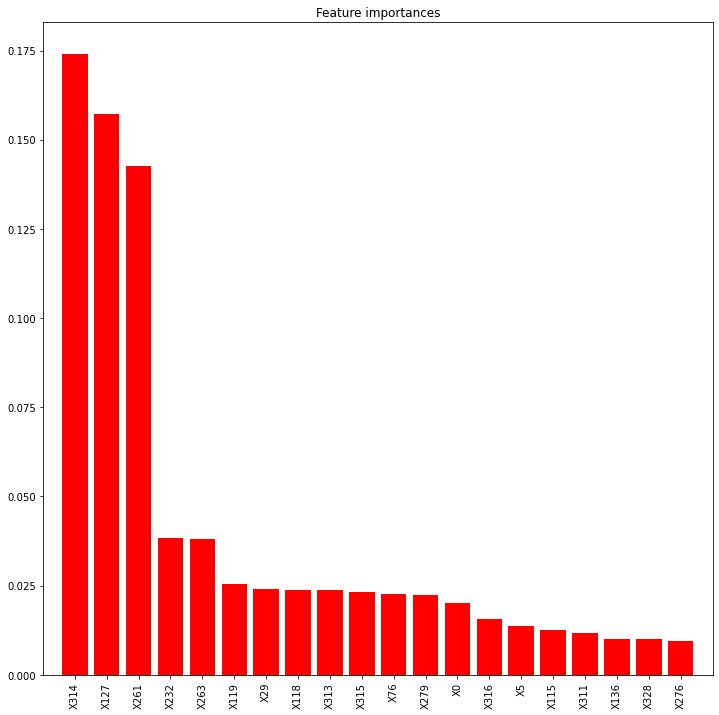

In [17]:
## Let us build a Random Forest model and check the important variables.

from sklearn import ensemble
model = ensemble.RandomForestRegressor(n_estimators=200, 
                                       max_depth=10, min_samples_leaf=4, 
                                       max_features=0.2, n_jobs=-1, 
                                       random_state=0)
model.fit(x_train, y_train)
feat_names = x_train.columns.values

## plot the importances ##
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

In [18]:
# Performing dimensionality reduction with principal components analysis
from sklearn.decomposition import PCA
n_comp = 12
pca = PCA(n_components = n_comp, random_state = 42)
pca_result_train = pca.fit_transform(x_train)
##pca_result_test = pca.transform(x_test)


In [19]:
#print(pca_result_train)
#print(pca_result_test)

In [20]:
# ML Modeling with XGboost
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# Splitting the data by 80/20
x_train, x_valid, y_train, y_valid = train_test_split(pca_result_train, 
                                                      y_train, 
                                                      test_size = 0.2, 
                                                      random_state = 42)

In [21]:
# Building the final feature set
f_train = xgb.DMatrix(x_train, label = y_train)
f_valid = xgb.DMatrix(x_valid, label = y_valid)

#f_test = xgb.DMatrix(pca_result_test)

## DMatrix is an internal data structure that is used by XGBoost, 
## which is optimized for both memory efficiency and training speed.

## https://xgboost.readthedocs.io/en/latest/python/python_api.html

In [22]:
# Setting the parameters for XGB
params = {}
params['objective'] = 'reg:linear'
params['eta'] = 0.02  ## eta means learning rate
params['max_depth'] = 4

In [23]:
# Predicting the score
# Creating a function for the same

def scorer(m, w):
    labels = w.get_label()
    return 'r2', r2_score(labels, m)

final_set = [(f_train, 'train'), (f_valid, 'valid')]

#1000 decision trees are being added
P = xgb.train(params, f_train, 1000, final_set, early_stopping_rounds=50, feval=scorer, maximize=True, verbose_eval=10)

## xgb.train: eXtreme Gradient Boosting Training
## xgb.train is an advanced interface for training an xgboost model.
## https://www.rdocumentation.org/packages/xgboost/versions/1.4.1.1/topics/xgb.train

[09:52:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:98.99704	train-r2:-59.49743	valid-rmse:98.88675	valid-r2:-61.82424
[10]	train-rmse:81.14532	train-r2:-39.64615	valid-rmse:81.05431	valid-r2:-41.20883
[20]	train-rmse:66.60017	train-r2:-26.38061	valid-rmse:66.52771	valid-r2:-27.43520
[30]	train-rmse:54.76084	train-r2:-17.51112	valid-rmse:54.72092	valid-r2:-18.23791
[40]	train-rmse:45.14307	train-r2:-11.57983	valid-rmse:45.11907	valid-r2:-12.07891
[50]	train-rmse:37.35343	train-r2:-7.61298	valid-rmse:37.35661	valid-r2:-7.96573
[60]	train-rmse:31.07077	train-r2:-4.95932	valid-rmse:31.08922	valid-r2:-5.20970
[70]	train-rmse:26.02810	train-r2:-3.18194	valid-rmse:26.04551	valid-r2:-3.35830
[80]	train-rmse:22.00456	train-r2:-1.98894	valid-rmse:22.02657	valid-r2:-2.11706
[90]	train-rmse:18.81812	train-r2:-1.18597	valid-rmse:18.84557	valid-r2:-1.28176
[100

In [24]:
# Predicting on test set
#p_test = P.predict(f_test)
p_test = P.predict(f_valid)
p_test

array([ 92.592865,  96.851364, 102.64923 ,  79.46705 , 111.11178 ,
       101.86868 ,  92.87231 , 102.73963 , 103.28341 , 114.45355 ,
        76.90071 ,  96.14051 ,  97.27842 , 103.10713 ,  96.18952 ,
        95.92386 , 109.23982 ,  97.03336 ,  95.065475, 115.34622 ,
       113.624176,  97.69768 ,  95.80118 , 101.38151 ,  93.715225,
       111.21973 ,  95.64712 ,  78.08221 ,  93.415985,  94.498474,
        94.921585, 102.04619 ,  96.28558 , 109.05853 ,  98.06487 ,
       114.28747 , 112.87755 ,  99.333244,  92.59446 ,  98.92737 ,
       114.08015 , 101.905075, 119.12566 , 108.742676,  96.52782 ,
       102.02457 ,  91.62731 , 103.81592 , 109.63143 , 104.70231 ,
        94.94296 ,  99.73851 , 103.5587  , 106.87215 ,  99.95413 ,
       101.46886 ,  98.64658 , 111.584785,  95.69909 ,  97.569115,
       109.13047 ,  76.614456,  95.38426 ,  95.71098 ,  77.54434 ,
        98.49977 ,  94.57728 , 100.03555 , 104.70231 ,  99.75031 ,
        94.11511 ,  94.69793 ,  98.91017 , 105.74342 ,  95.953

In [25]:
Predicted_Data = pd.DataFrame()
Predicted_Data['y'] = p_test
Predicted_Data.head()

,y
0,92.592865
1,96.851364
2,102.649231
3,79.467049
4,111.111778


In [31]:
from sklearn.metrics import mean_squared_error
import numpy as np
print(np.sqrt(mean_squared_error(y_valid, p_test)))

9.131376983037843
